In [1]:
from scipy.io.wavfile import read as wav_read
import numpy as np
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
import math
from scipy.interpolate import UnivariateSpline
from scipy.signal import spectrogram
import subprocess as sp
from warnings import warn

%matplotlib inline

In [2]:
def normalize(wave):
    def unbias(wave):
        return wave - wave.mean()
    wave = unbias(wave)
    return wave / np.max(np.abs(wave))

# Загрузка файла

In [3]:
rate, wave = wav_read('./rec_notes/kuznechik_short.wav')
#rate, wave = wav_read('./rec_notes/katusha_long.wav')
wave = normalize(wave)
length = wave.shape[0] / rate
cnt = 100

In [4]:
length

11.72607709750567

In [5]:
def time_to_wi(time, rate):
    return (time * rate).astype(int)

In [6]:
def wi_to_time(wi, rate):
    return wi / rate

# Поиск тишины

In [7]:
cnt_per_sec = 10
VOLUME_FOR_SILENCE = 0.03

def est1(seg):
    return np.mean(np.abs(seg))

def get_silence(wave):
    segs_num = int(length * cnt_per_sec)
    is_silence = np.zeros(shape=segs_num)
    for i in range(segs_num):
        s1 = rate * i // cnt_per_sec
        s2 = rate * (i + 1) // cnt_per_sec
        vol = est1(wave[s1:s2])
        is_silence[i] = 1 if vol > VOLUME_FOR_SILENCE else 0
    return is_silence

In [8]:
MIN_SEGMENT_LENGTH = 1

def eject_list_of_segments_silenceless(oldwave):
    old_silence_mask = get_silence(wave)
    silence_mask = np.concatenate(([0], old_silence_mask, [0]))
    
    d = silence_mask[1:] - silence_mask[:-1]
   
    start = np.argwhere(d > 0).ravel()
    stop  = np.argwhere(d < 0).ravel()
    
    segments = []
    pauses_lens = [0.5]
    for i in np.arange(start.shape[0]):
        new_part = wave[time_to_wi(start[i] / cnt_per_sec, rate) : time_to_wi(stop[i] / cnt_per_sec, rate)]
        if len(new_part) > MIN_SEGMENT_LENGTH:
            segments.append(new_part)
            pauses_lens.append(0.0)
        if i < len(start) - 1:
            pauses_lens[len(pauses_lens) - 1] += (start[i + 1]  - stop[i]) / cnt_per_sec
    #return start, stop, pauses_lens
    return start / cnt_per_sec, stop / cnt_per_sec, pauses_lens

In [9]:
seg_starts, seg_stops, pauses_lens = eject_list_of_segments_silenceless(wave)
# list_of_segments, pauses_lens
print(len(seg_starts))
print(len(seg_stops))
print(len(pauses_lens))

2
2
3


# Автокорреляция

In [10]:
def run_ps(*args):
    sp.ru41n(args, check=True)

In [11]:
def show(ys):
    ts = np.arange(ys.shape[0])
    plt.figure(figsize=(15, 6))
    plt.plot(ts, ys)

In [12]:
def determine(left, right):
    base = 440
    i1 = math.log(left / base) / math.log(2) * 12
    i2 = math.log(right / base) / math.log(2) * 12
    i1 = math.ceil(i1)
    i2 = math.floor(i2)
    if i1 == i2:
        return i1
    else:
        warn("choose between {}, {}".format(i1, i2))
        return i1

In [13]:
def get_pitch(wave, pos, length):
    # print(wave.shape, pos)
    try:
        wave = wave[pos:]
        wave = wave[:int(length / cnt * rate)]
        # wave = np.hamming(wave.shape[0]) * wave

        nwave = np.zeros(shape=wave.shape[0] * 2)
        nwave[:wave.shape[0]] = wave
        window = np.flipud(nwave)

        corr = ifft(fft(nwave) * fft(window)).real
        n = corr.shape[0]
        corr = np.roll(corr, n)[:n]

        # show(corr)
        # plt.show()

        corr = corr[:corr.shape[0] // 2]
        diff = np.diff(corr)
        maxs = np.argwhere(np.logical_and(diff[:-1] > 0, diff[1:] < 0)).squeeze()
        maxs = maxs[np.argwhere(corr[maxs] > 0.95 * corr[maxs].max()).squeeze()]
        # print(maxs)
        if len(maxs.shape) == 0:
            ind = int(maxs)
        else:
            ind = maxs[0]

        # print(ind)
        if ind == 1:
            show(corr)
        return rate / (ind + 2), rate / (ind if ind != 0 else 1)
    except Exception as e:
        return 1, 10

In [14]:
def show_results(wave, rate, predict):
    predict = np.asanyarray(predict)
    wave = np.asanyarray(wave)
    fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(ts, fs[:256], np.log(sxx[:256, :]))
    plt.plot(np.arange(0, len(predict) / cnt, 1 / cnt), 440 * 2 ** (predict / 12), color='black')
    plt.ylim(0, 4096 / 4)
    plt.show()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between -15, -16
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between -14, -15
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between -13, -14
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between -18, -19
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between -17, -18
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: UserWarning: choose between -12, -13
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10:

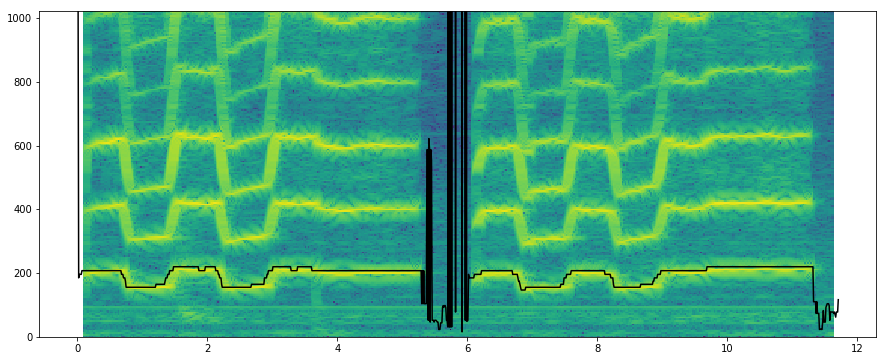

In [15]:
res = []
for pos in np.arange(0, length - 1 / cnt, 1 / cnt):
    pitch = get_pitch(wave, int(pos * rate), length)
    det = determine(*pitch)
    res.append(det)
show_results(wave, rate, res)

In [16]:
fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
step = 4096 * 2 // 8
v = sxx[:400, int(rate * 13.2 // step)].ravel()
#v[:150] = 0

plt.figure(figsize=(15, 6))
plt.plot(fs[:400], v, color='black')
plt.show()
#(np.log(v))
#show(v)

IndexError: index 568 is out of bounds for axis 1 with size 498

In [17]:
def est1(seg):
    return np.mean(np.abs(seg))

def est2(seg):
    return np.mean(seg ** 2)

def est3(seg):
    return np.max(np.abs(fft(seg)))

def estimate_volume(wave, framerate, seg_length, func):
    length = wave.shape[0] / framerate
    ts = []
    res = []
    for pos in np.arange(0, length, seg_length):
        left = int(pos * framerate)
        right = int((pos + seg_length) * framerate)
        seg = wave[left:right].astype(np.float)
        if seg.shape[0] == 0:
            break
        ts.append(pos)
        res.append(func(seg))
    return np.array(ts), np.array(res)

In [18]:
def split(predict, eps, k=10):
    res = []
    for i in range(k, len(predict)):
        if abs(predict[i] - predict[i - k]) > eps:
            res.append(i - k)
    return np.array(res)

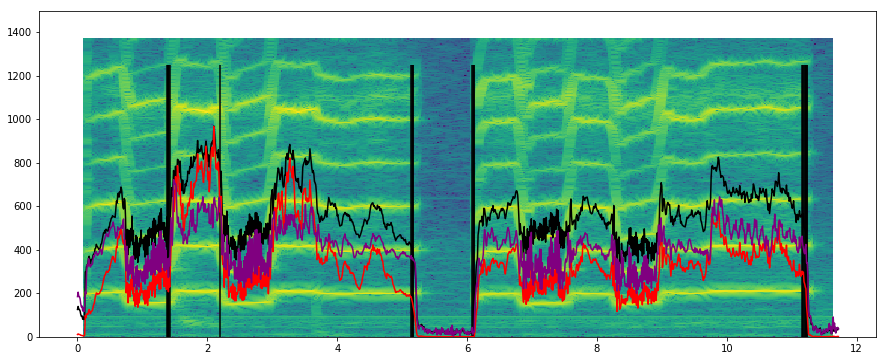

In [19]:
plt.figure(figsize=(15, 6))
ts, vol = estimate_volume(wave, rate, 1 / cnt, est1)
plt.plot(ts, vol * 3000, color='black')
ts, vol = estimate_volume(wave, rate, 1 / cnt, est2)
plt.plot(ts, vol * 6000, color='red')
ts, vol = estimate_volume(wave, rate, 1 / cnt, est3)
plt.plot(ts, vol * 10, color='purple')
spl = split(vol, 30)
plt.vlines(spl * ts[1], 0, 1250)
fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
plt.ylim((0, 1500))
plt.pcolormesh(ts, fs[:256], np.log(sxx[:256, :]))

# [Анализ]

In [22]:
import peakutils

In [23]:
indexes = peakutils.indexes(v, thres=0.2, min_dist=0.1)
indexes

NameError: name 'v' is not defined

In [24]:
fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
v = sxx[:500, int(rate * 13.2 // step)].ravel()

plt.figure(figsize=(15, 6))
plt.plot(fs[:500], v, color='black')
plt.scatter(fs[indexes], v[indexes], marker='x')
plt.xlim((0, 1000))
plt.show()

IndexError: index 568 is out of bounds for axis 1 with size 498

Получаем список разниц между слоями

'''
differ_indexes = []
differ_values = []
for i in range(sxx.shape[1]):
    current_slice = sxx[:500, i].ravel()
    indexes = peakutils.indexes(current_slice, thres=0.3, min_dist=0.2)
    
    if len(indexes) > 1 and len(indexes) < 4:
        newvalue = np.average(fs[indexes[1:]] - fs[indexes[:-1]])
        differ_indexes.append(i)
        indexes = peakutils.indexes(current_slice, thres=0.3, min_dist=0.2)
    
    if len(indexes) > 1 and len(indexes) < 4:
        newvalue = np.average(fs[indexes[1:]] - fs[indexes[:-1]])
        differ_indexes.append(i)
        differ_values.append(newvalue)
        differ_values.append(newvalue)'''

def show_results_difference(wave, rate, predict):
    predict = np.asanyarray(predict)
    wave = np.asanyarray(wave)
    fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(ts, fs[:256], np.log(sxx[:256, :]))
    plt.plot(np.arange(0, len(predict) / cnt, 1 / cnt), 440 * 2 ** (predict / 12), color='black')
    plt.plot(ts[differ_indexes], differ_values, color='red')
    plt.ylim(0, 4096 / 4)

show_results_difference(wave, rate, res)

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
    # except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

# Фильтрация

In [25]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')

In [26]:
def show_results_filtered(wave, rate, predict, correcteddata, times):
    predict = np.asanyarray(predict)
    wave = np.asanyarray(wave)
    fs, ts, sxx = spectrogram(wave, rate, nperseg=4096 * 2, noverlap=4096 * 2 * 7 // 8)
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(ts, fs[:256], np.log(sxx[:256, :]))
    plt.plot(np.arange(0, len(predict) / cnt, 1 / cnt), 440 * 2 ** (predict / 12), color='black')
    plt.plot(times, 440 * 2 ** (predict / 12), color='black')
    plt.plot(times, 440 * 2 ** (correcteddata / 12), color='blue')
    
    plt.ylim(0, 1000)
    #plt.xlim((11, 20))
    plt.show()

In [27]:
PEAK_FACTOR = 0.5
MAX_PEAK_LENGTH = 50

def filter_lunges_in_segment(olddata, times):
    
    data = olddata[:]

    # data = np.array([data]) 
    
#     print(times.shape)
    
    #print(data.shape)
#     print('trying to get data (len=', len(data), ')', data)
    smooth_data = movingaverage(data, np.minimum(70, len(data))) #UnivariateSpline(times, data.ravel(), s=0.05)(times)
    #smooth_data = UnivariateSpline(times, data.ravel(), s=50000, k=2)(times)
    
    i = 1
    places = []
    while i < len(data):
        print(i)
        j = 0
        if np.abs(data[i] - smooth_data[i]) > PEAK_FACTOR * np.abs(smooth_data[i]):
            last_sign = data[i] - smooth_data[i-1]
            places.append(i)
#             print('peak in', i, 'data[i]=', data[i], 'data[i-1]=', data[i-1], 'smdata=', smooth_data[i])
            delta = data[i] - data[i-1]
            start_value = data[i-1]
#             print('delta = ', delta)
            while j < MAX_PEAK_LENGTH and i + j < len(data) :                
                if (not (np.abs(data[i+j] - smooth_data[i+j]) > PEAK_FACTOR * np.abs(smooth_data[i+j]))) or (data[i+j] - smooth_data[i+j]) * last_sign < 0:
#                     if (data[i+j] - smooth_data[i+j]) * last_sign < 0:
#                         j -= 1
#                     print('breakin')
                    break
                # data[i+j] = start_value + (start_value + data[i+j] % 12)# += delta
                data[i+j] -= delta
                j += 1
        i = i + j + 1    
    
    #show_results_filtered(wave, rate, olddata, smooth_data, np.array(data), times.ravel(), places)
    print(len(data))
    print(len(olddata))
    
    return data

In [28]:
length * cnt

1172.607709750567

In [29]:
SILENCE_CONST = -1108

def filter_all_segments(predict, seg_starts, seg_stops, pauses):
   
#     predict = np.asanyarray(predict)

    times = np.arange(0, len(predict) / cnt, 1 / cnt)
    pr_len = len(predict)
    
#     print('KKKKKKKKKK', pr_len)
    
    near_notes = np.array(predict[:])
    
    start = (seg_starts * cnt).astype(int)
    stop = (seg_stops * cnt).astype(int)
    
    tmp1 = start[0] - 1 if start[0] > 0 else 0
    tmp2 = (stop[len(stop) - 1] + 1 if start[0] > 0 else 0)
    print((tmp1, tmp2))
    near_notes[:tmp1] = SILENCE_CONST
    near_notes[tmp2:] = SILENCE_CONST
    print('hey!')
    for i in np.arange(len(start)):
        l = start[i]
        r = stop[i]
#         print(i)
#         print('L=', l, 'R=', r)
        if (i > 0):
             near_notes[stop[i-1] : start[i]] = SILENCE_CONST  
        print('k then')
#         print('predictlr', len(predict[l:r]))
        near_notes[l:r] = filter_lunges_in_segment(predict[l:r], times[l:r])
    return near_notes

(0, 0)
hey!
k then
1
3
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281


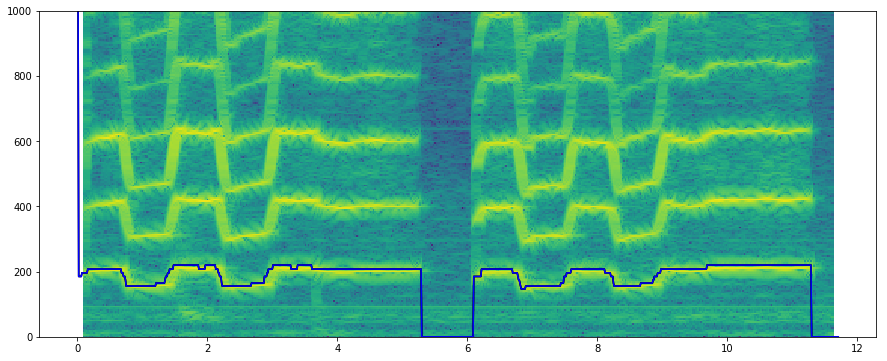

In [30]:
corrected_notes = filter_all_segments(res, seg_starts, seg_stops, pauses_lens)
show_results_filtered(wave, rate, corrected_notes, corrected_notes, np.arange(0, len(corrected_notes) / cnt, 1 / cnt))

# Восстановление кусочно-постоянной функции

In [31]:
class DSU:
    def __init__(self, count):
        self.ar = list(range(count))
        self.rank = [0] * count
        self.get = self.get_col
    def get_col(self, index):
        if self.ar[index] == index:
            return index
        self.ar[index] = self.get_col(self.ar[index])
        return self.ar[index]
    def unite(self, a, b):
        a = self.get_col(a)
        b = self.get_col(b)
        if self.rank[a] > self.rank[b]:
            a, b = b, a
        self.ar[a] = b
        if self.rank[a] == self.rank[b]:
            self.rank[b] += 1

In [32]:
def k_means(seg, k):
    dsu = DSU(len(seg))
    for ind in np.argsort(np.abs(np.diff(seg)))[:-k+1]:
        dsu.unite(ind, ind + 1)
    last = -1
    last_pos = 0
    segs = []
    for i in range(len(seg)):
        t = dsu.get(i)
        if t != last:
            if last != -1:
                segs.append((last_pos, i - 1))
            last_pos = i
            last = dsu.get(i)
    segs.append((last_pos, len(seg) - 1))
    return segs

In [33]:
def k_means_2(seg, k):
    segs = [(i, i + 1) for i in range(len(seg))]
    for i in range(len(seg) - k + 1):
        mval = 1e10
        pos = -1
        for j in range(len(segs) - 1):
            u1, u2 = segs[j]
            v1, v2 = segs[j + 1]
            m1 = np.median(seg[u1:u2])
            m2 = np.median(seg[v1:v2])
            if mval > abs(m1 - m2):
                mval = abs(m1 - m2)
                pos = j
        segs[pos] = (segs[pos][0], segs[pos + 1][1])
        del segs[pos + 1]
    return segs

530
520


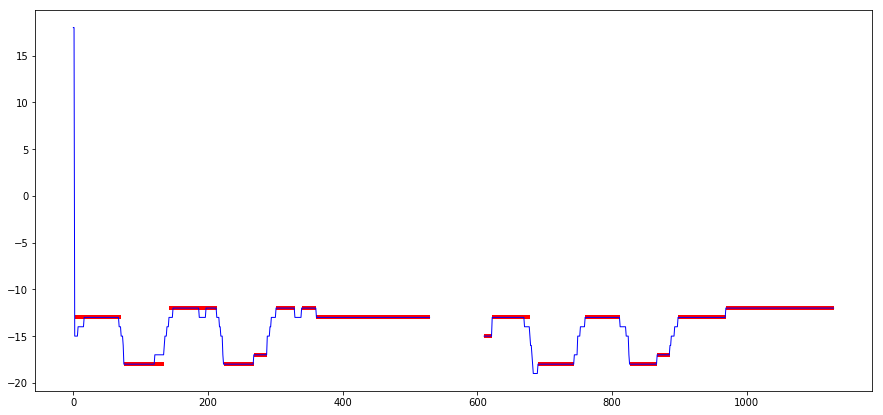

In [34]:
MIN_NOTE_LENGTH = 0.1 # secs
NOTES_PER_PHRASE = 20

start = (seg_starts * cnt).astype(int)
stop = (seg_stops * cnt).astype(int)

plt.figure(figsize=(15, 7))

all_segments = []

for i in np.arange(len(start)):
    seg = corrected_notes[start[i]:stop[i]]
    
    kmeans_notes = k_means_2(seg, k=NOTES_PER_PHRASE)
    
    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(len(corrected_notes))[start[i]:stop[i]], seg, color='blue', lw=1)
    for u, v in kmeans_notes:
        if (v - u) / cnt > MIN_NOTE_LENGTH:
            all_segments.append((u + start[i], v + start[i], np.median(seg[u:v])))
            plt.hlines(np.median(seg[u:v]), u + start[i], v + start[i], color='red', lw=4)
    
    #plt.ylim(0, 100)
    #plt.xlim((11, 20))
    plt.show()
    
    print(len(seg))
    

# ПИЛИКАЛКА

Пример использования

In [35]:
import importlib as imp
import synthesis
imp.reload(synthesis)
from synthesis import AudioBuilder

In [36]:
r = 44100
builder = AudioBuilder(length=3.0, rate=r)


builder.add_freq(0, 0, dur=r // 4)
builder.add_freq(2, r // 2, amp=0.5, dur=r // 4)
builder.add_freq(4, r, amp=0.25, dur=r // 4)
builder.write('output.wav')

In [37]:
def float_to_time(ind, rate):
    return int(ind * rate)

In [38]:
'''r = 44100
builder = AudioBuilder(length=25.0, rate=r)

lsize = len(corrected_notes)
times = np.arange(0, len(corrected_notes) / cnt, 1 / cnt)

for i in range(0, lsize, 5):
    builder.add_freq(corrected_notes[i], float_to_time(times[i], r), dur=float_to_time(5/ cnt, r))

builder.write('output.wav')'''

"r = 44100\nbuilder = AudioBuilder(length=25.0, rate=r)\n\nlsize = len(corrected_notes)\ntimes = np.arange(0, len(corrected_notes) / cnt, 1 / cnt)\n\nfor i in range(0, lsize, 5):\n    builder.add_freq(corrected_notes[i], float_to_time(times[i], r), dur=float_to_time(5/ cnt, r))\n\nbuilder.write('output.wav')"

In [39]:
r = 44100
builder = AudioBuilder(length=length+2.0, rate=r)

lsize = len(all_segments)

In [40]:
for left, right, frq in all_segments:
    builder.add_freq(int(frq), int((left / cnt) * r), dur=int((right-left) / cnt * r))

builder.write('output.wav')